In [6]:
%matplotlib inline
import pylab as plt
import pandas as pd
import numpy as np
import scipy as sp

from sklearn.model_selection import GridSearchCV

import relplot as rp
from relplot.diagrams import rel_diagram, rel_diagram_binned
from relplot.metrics import smECE
import relplot.diagrams as rd
from relplot.estimators import Binning

In [7]:
rp.config.use_tex_fonts = True
rp.diagrams.set_default_style()

In [8]:
def plot_compare(f, y, **kwargs):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    f, y = map(lambda x: np.array(x, dtype=np.double).reshape(-1).copy(), [f, y])

    plot_params = dict(split_densities=False, plot_density_ticks=True, plot_density=True, plot_confidence_band=False)
    if kwargs is not None:
        plot_params.update(kwargs)
    num_bootstrap=500

    binning = GridSearchCV(Binning(), param_grid={'bins_cnt': range(10, 25, 1)}, cv=5, scoring='neg_mean_squared_error', verbose=1)
    binning.fit(f.reshape(-1, 1), y-f)
    nbins = binning.best_params_['bins_cnt']
    # binning = Binning(15)

    _ = rd.rel_diagram_binned(f, y, fig=fig, ax=axs[0], nbins=nbins);
    axs[0].set_title('BinnedECE')
    
    _ = rd.rel_diagram(f, y, fig=fig, ax=axs[1], num_bootstrap=num_bootstrap, **plot_params)
    axs[1].set_title('SmoothECE (Ours)')
    return fig, axs

## DNN calibration

In [9]:
def load_plot_save(suffix, fname):
    url = f'https://raw.githubusercontent.com/hollance/reliability-diagrams/master/results/{suffix}'
    df = pd.read_csv(url)
    f = df['confidence'].to_numpy()
    y = (df['true_label'] == df['pred_label']).to_numpy()*1.0
    fig, axs = plot_compare(f, y)
    # fig.savefig(f'./figures/{fname}', dpi=150, bbox_inches='tight') # Don't save fig for demo purposes.

Fitting 5 folds for each of 15 candidates, totalling 75 fits


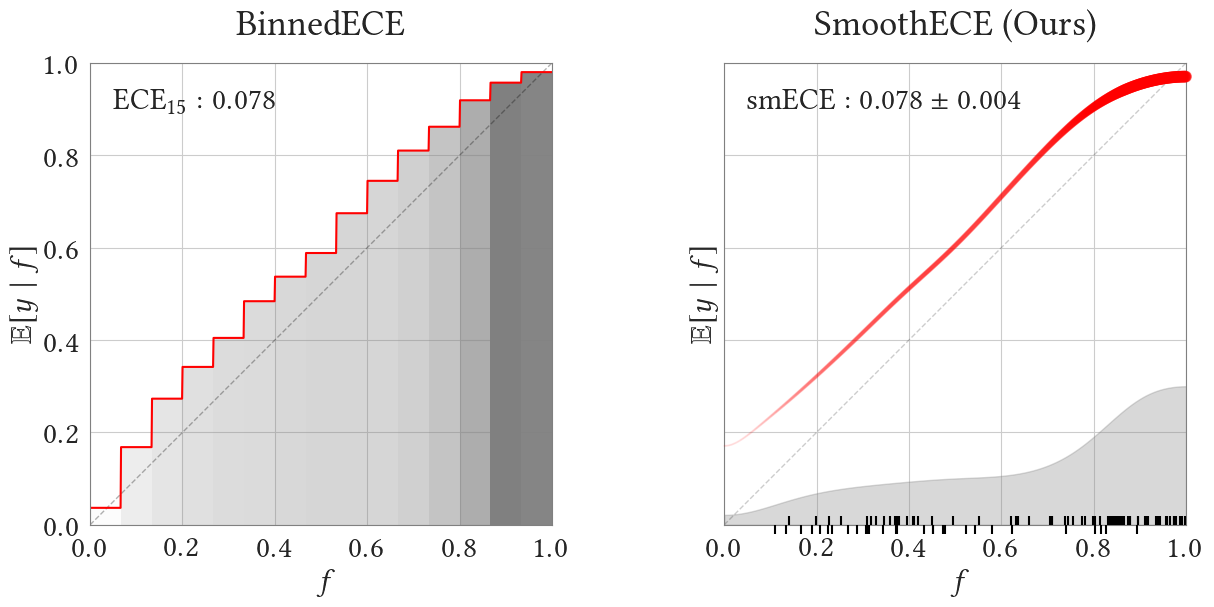

In [10]:
load_plot_save('ImageNet_pytorch-image-models/resnet34.csv', 'resnet34.png')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


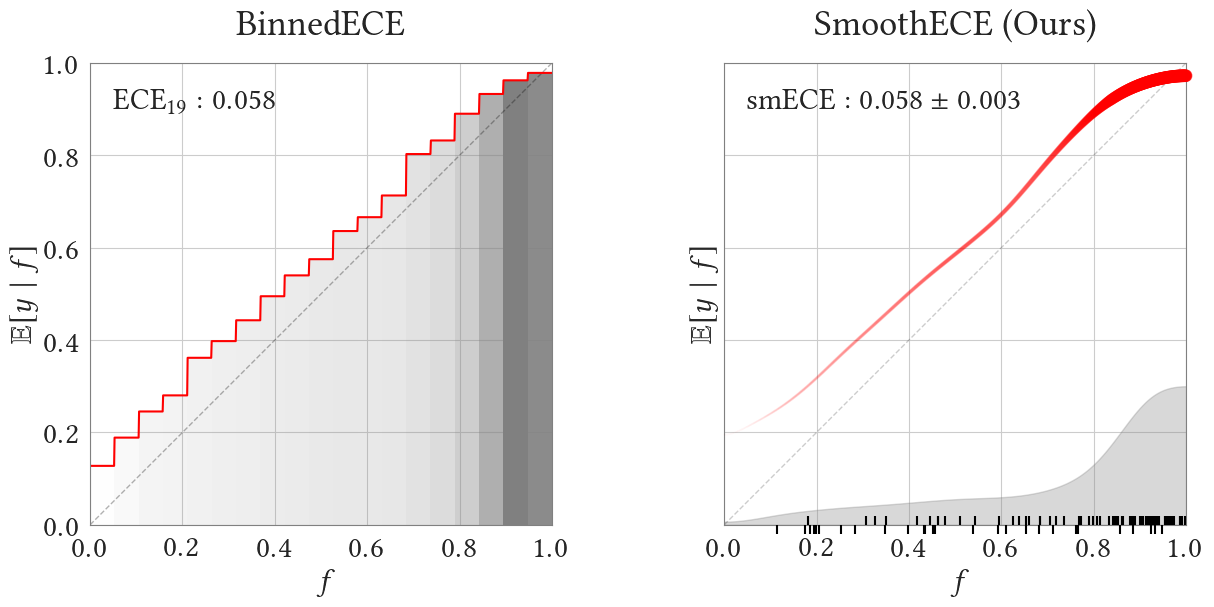

In [12]:
load_plot_save('ImageNet_pytorch-image-models/resnext50_32x4d.csv', 'resnext50_32x4d.png')

## Solar Flares

      DAFFS  NOAA  rlz.C1
0  0.778454  0.70       1
1  0.667816  0.75       0
2  0.133650  0.30       0
3  0.176088  0.35       0
4  0.187407  0.30       0
Fitting 5 folds for each of 15 candidates, totalling 75 fits


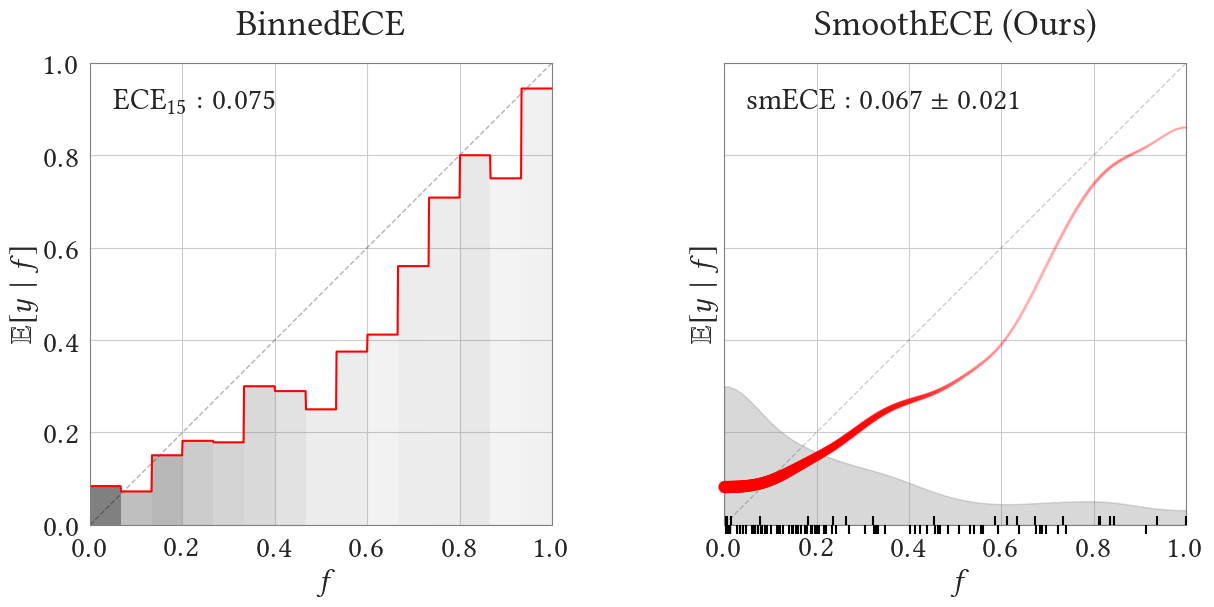

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/TimoDimi/replication_DGJ20/master/data/SF.FC.C1.csv')
f = df['DAFFS'].to_numpy().copy()
y = df['rlz.C1'].to_numpy().copy()
print(df[['DAFFS', 'NOAA', 'rlz.C1']].head())

fig, axs = plot_compare(f, y)
# fig.savefig(f'./figures/solar_flares.png', dpi=150, bbox_inches='tight')

## Rain in Finland

Fitting 5 folds for each of 15 candidates, totalling 75 fits


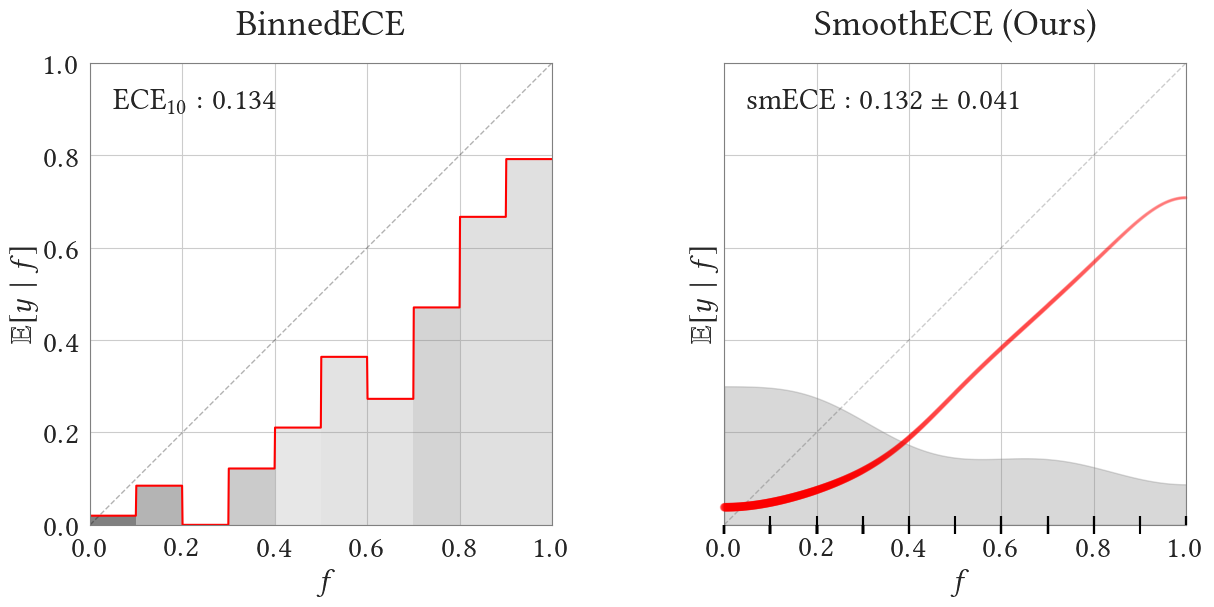

In [15]:
# https://www.cawcr.gov.au/projects/verification/POP3/POP3.html
df = pd.read_csv('https://www.cawcr.gov.au/projects/verification/POP3/POP_3cat_2003.txt', delim_whitespace=True, header=0)

obs = df['obs(mm)']
cat0 = df['p24_cat0']
df = df.loc[obs.abs() < 100] # valid entries
df = df.loc[(cat0 <= 1) & (cat0 >= 0)] 

y = (df['obs(mm)'] > 0.2).to_numpy() * 1.0
f = 1.0 - df['p24_cat0'].to_numpy()

fig, axs = plot_compare(f, y)
# fig.savefig(f'./figures/rain_finland.png', dpi=150, bbox_inches='tight')

## Synthetic

In [17]:
def prepare_dataset(n, skew_function):
    res = []
    fa = []
    ya = []
    for _ in range(n):
        f = np.random.uniform()
        y = int(np.random.uniform() > 1 - skew_function(f))
        fa.append(f)
        ya.append(y)
    return np.array(fa), np.array(ya)

def temp_scale(f, beta):
    return np.power(f, beta) / (np.power(f, beta) + np.power(1-f, beta))
    
def get_temp_scaled_dataset(N, beta):
    S = prepare_dataset(N, lambda x: x) # perfectly calibrated
    S[0] = temp_scale(S[0], beta)
    return S

intCE-width: 0.0458984375


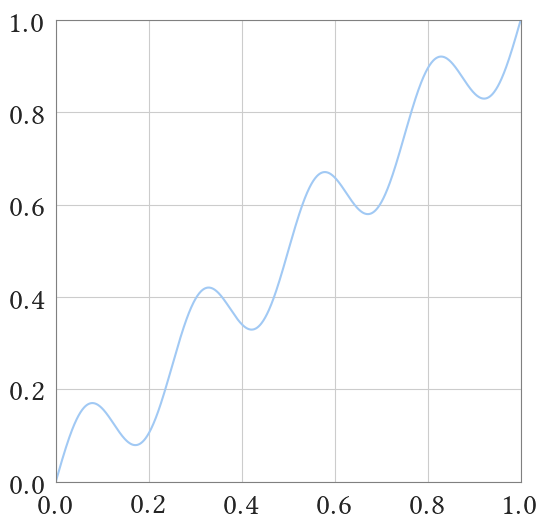

In [18]:
t = np.linspace(0, 1, 1000)

def skew(x):
    z = (2*x - 1) # [-1, 1]
    z = z + 0.2*np.sin(4*np.pi*z)
    zn = (z+1)/2
    return zn

plt.plot(t, skew(t))
plt.xlim((0, 1))
plt.ylim((0, 1))

np.random.seed(0)
f, y = prepare_dataset(1000, skew)
_, wid = smECE(f, y, return_width=True)
print('intCE-width:', wid)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


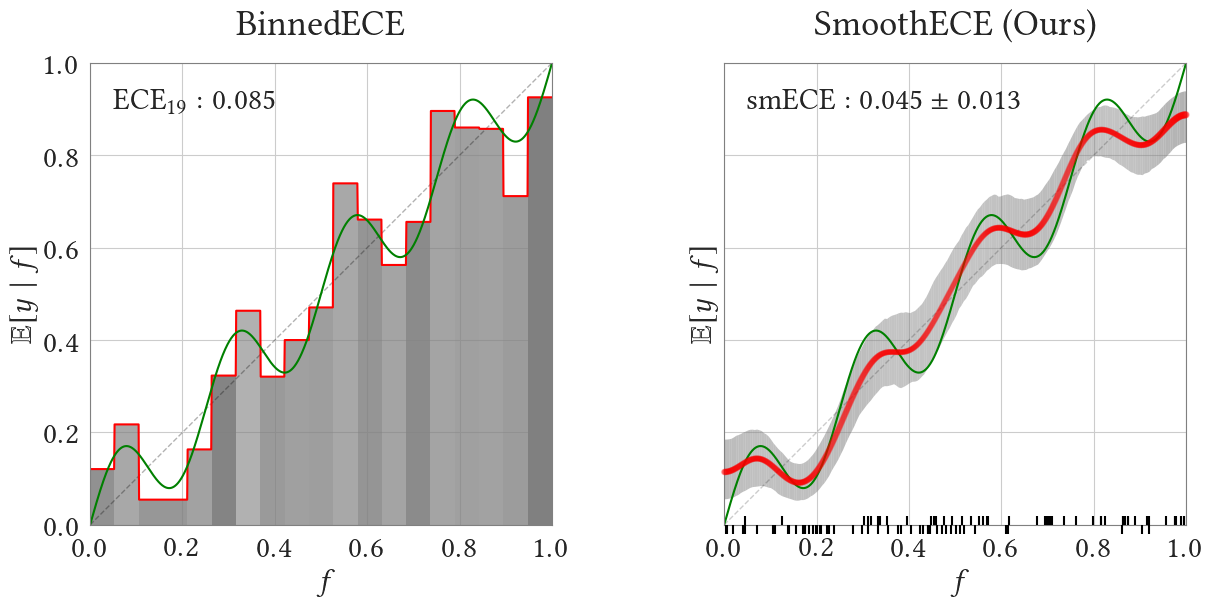

In [20]:
fig, axs = plot_compare(f, y, plot_confidence_band=True, plot_density_ticks=True, plot_density=False);

t = np.linspace(0, 1, 1000)
for ax in axs:
    ax.plot(t, skew(t), 'g-')